In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras.utils

In [10]:
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('D:/ML/LeoRepository/recommender-tensorflow/src/data/mlBinary.csv', header=0, names=['id','movie_id','user_id', 'rating'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print ('Number of movies', num_movies)
print ('Number of users', num_users)

Number of movies 1682
Number of users 943


In [11]:
train.head()

,id,movie_id,user_id,rating
121093,121093,164,294,0.0
38119,38119,550,478,1.0
141538,141538,199,179,0.0
65453,65453,101,553,1.0
168233,168233,582,519,0.0


In [12]:
test.head()

,id,movie_id,user_id,rating
56922,56922,142,87,1.0
117094,117094,529,172,0.0
182397,182397,582,739,0.0
10503,10503,470,271,1.0
42801,42801,601,536,1.0


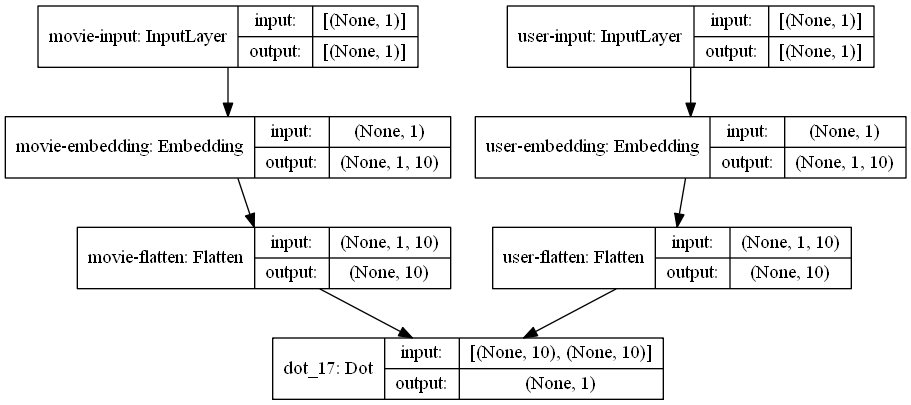

In [63]:
from keras.models import Model, Sequential
from keras.layers import *
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = tf.keras.layers.Dot(axes=1)([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error', metrics=['mse', 'mae'])

plot_model(model, show_shapes=True)

In [64]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 10)        16830       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        9440        user-input[0][0]                 
___________________________________________________________________________________________

Epoch 1/10
4766/4766 [==============================] - 12s 2ms/step - loss: 0.4187 - mse: 0.4187 - mae: 0.4752
Epoch 2/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.1356 - mse: 0.1356 - mae: 0.2877
Epoch 3/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.1194 - mse: 0.1194 - mae: 0.2605
Epoch 4/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.1106 - mse: 0.1106 - mae: 0.2452
Epoch 5/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.1028 - mse: 0.1028 - mae: 0.2318
Epoch 6/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.0970 - mse: 0.0970 - mae: 0.2226
Epoch 7/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.0948 - mse: 0.0948 - mae: 0.2193
Epoch 8/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.0920 - mse: 0.0920 - mae: 0.2149
Epoch 9/10
4766/4766 [==============================] - 11s 2ms/step - loss: 0.0899 - mse: 0.0899 - mae:

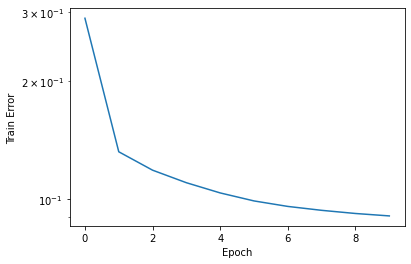

1192/1192 [==============================] - 2s 2ms/step - loss: 0.1066 - mse: 0.1066 - mae: 0.2312


[0.10663390904664993, 0.10663390904664993, 0.23117010295391083]

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

model.evaluate([test.user_id, test.movie_id], test.rating)

In [16]:
from keras.constraints import non_neg

latent_dim = 5

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding',
                                                        embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                                                      embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

#prod = merge([movie_vec, user_vec], mode='dot',name='dot-product')

prod = tf.keras.layers.Dot(axes=1)([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

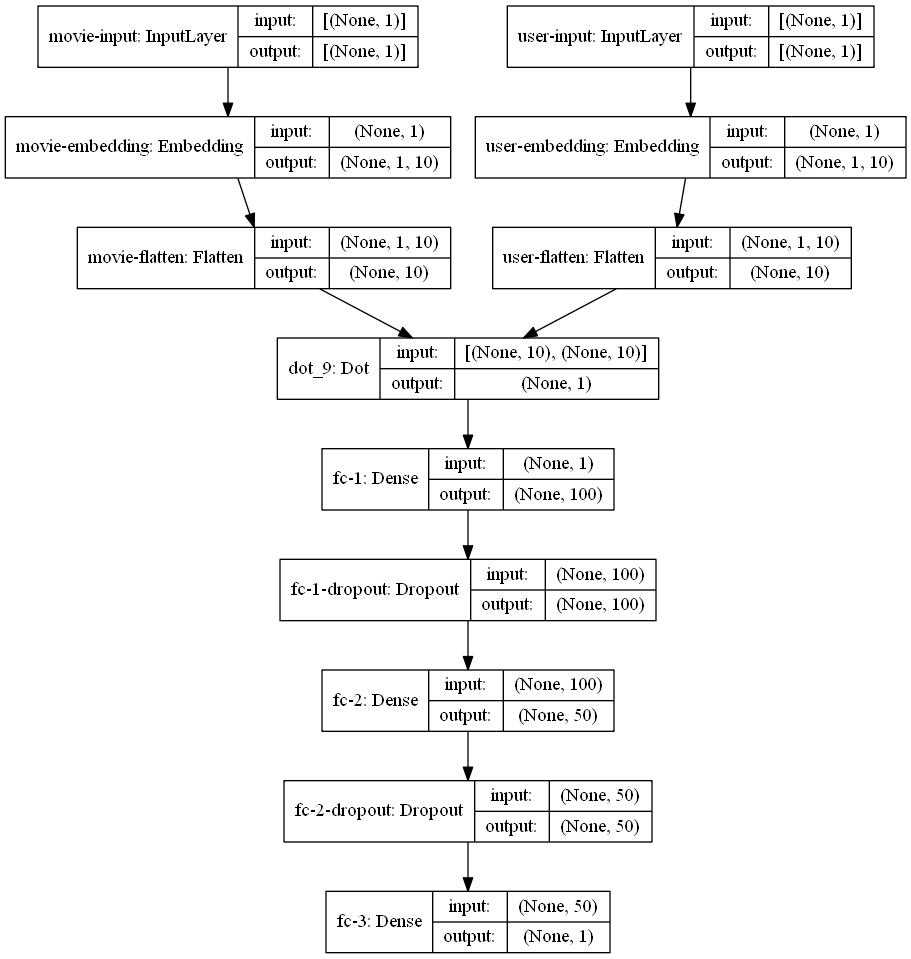

In [45]:
#neural network with MF starts here
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

movie_input = Input(shape=[1],name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1],name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = tf.keras.layers.Dot(axes=1)([movie_vec, user_vec])

fc_1 = Dense(100, name='fc-1', activation='sigmoid')(prod)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='sigmoid')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
fc_3 = Dense(1, name='fc-3', activation='sigmoid')(fc_2_dropout)

model = Model([user_input, movie_input], fc_3)

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.Accuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_k_categorical_accuracy', dtype=None)])

#SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
plot_model(model, show_shapes=True) #why is this extra line here

In [46]:
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding (Embedding)     (None, 1, 10)        16830       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding (Embedding)      (None, 1, 10)        9440        user-input[0][0]                 
____________________________________________________________________________________________

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=20)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

model.evaluate([test.user_id, test.movie_id], test.rating)

Epoch 1/20
4766/4766 [==============================] - 37s 7ms/step - loss: 0.1923 - mse: 0.1923 - mae: 0.3793 - false_negatives_4: 7847.9914 - false_positives_4: 12954.1133 - true_negatives_3: 23444.5383 - true_positives_3: 32041.3503 - accuracy: 0.0000e+00 - top_k_categorical_accuracy: 1.0000
Epoch 2/20
4766/4766 [==============================] - 35s 7ms/step - loss: 0.1090 - mse: 0.1090 - mae: 0.2121 - false_negatives_4: 5770.5893 - false_positives_4: 5857.9280 - true_negatives_3: 30391.2505 - true_positives_3: 34268.2255 - accuracy: 0.0000e+00 - top_k_categorical_accuracy: 1.0000
Epoch 3/20
4766/4766 [==============================] - 34s 7ms/step - loss: 0.0970 - mse: 0.0970 - mae: 0.1885 - false_negatives_4: 5122.5716 - false_positives_4: 5277.5859 - true_negatives_3: 30970.8053 - true_positives_3: 34917.0304 - accuracy: 0.0000e+00 - top_k_categorical_accuracy: 1.0000
Epoch 4/20
4766/4766 [==============================] - 36s 7ms/step - loss: 0.0910 - mse: 0.0910 - mae: 0.1757

KeyboardInterrupt: 

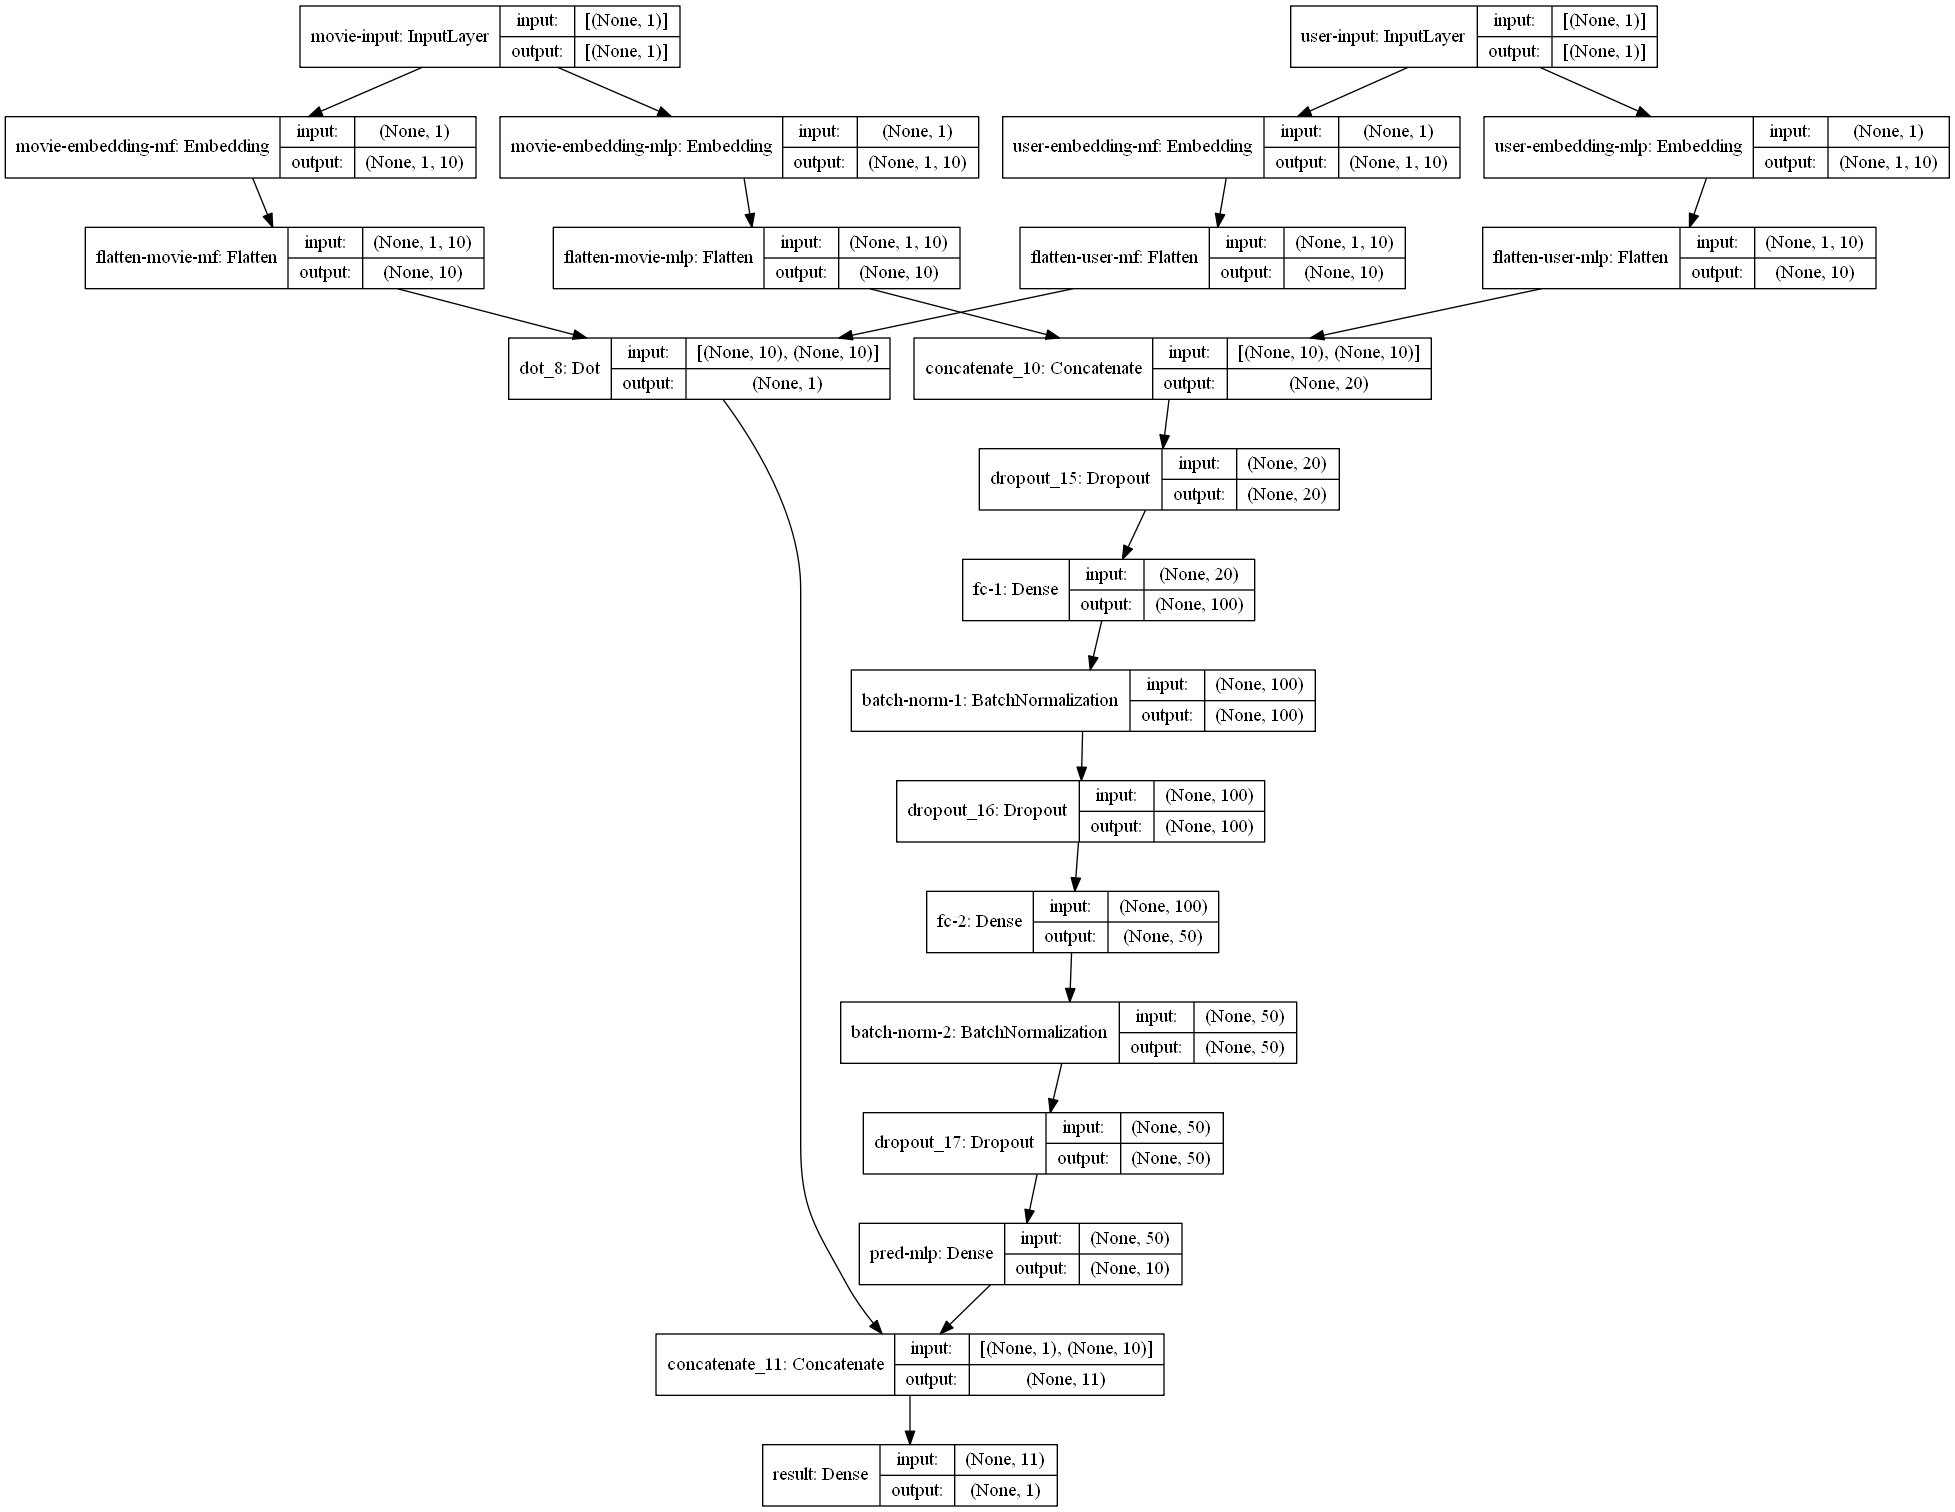

In [44]:
#multi-layer perceptor starts here
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, merge, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1],name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = tf.keras.layers.Concatenate(axis=-1)([movie_vec_mlp, user_vec_mlp])
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='sigmoid')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='sigmoid')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='sigmoid')(fc_2_dropout)
pred_mf = tf.keras.layers.Dot(axes=1)([movie_vec_mf, user_vec_mf])
combine_mlp_mf = tf.keras.layers.Concatenate(axis=-1)([pred_mf, pred_mlp])

# Final prediction
result = Dense(1, name='result', activation='sigmoid')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(lr=0.01), loss='mean_absolute_error', metrics=['mse', 'mae', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.TruePositives(), tf.keras.metrics.Accuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_k_categorical_accuracy', dtype=None)])

plot_model(model, show_shapes=True)

In [41]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie-input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user-input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie-embedding-mlp (Embedding) (None, 1, 10)        16830       movie-input[0][0]                
__________________________________________________________________________________________________
user-embedding-mlp (Embedding)  (None, 1, 10)        9440        user-input[0][0]                 
____________________________________________________________________________________________

Epoch 1/10
4766/4766 [==============================] - 45s 9ms/step - loss: 0.1451 - mse: 0.1436 - mae: 0.1451 - false_negatives_2: 10444.0000 - false_positives_2: 11681.0000 - true_negatives_1: 60873.0000 - true_positives_1: 69514.0000 - accuracy: 0.6987
Epoch 2/10
4766/4766 [==============================] - 45s 10ms/step - loss: 0.1430 - mse: 0.1418 - mae: 0.1430 - false_negatives_2: 10490.0000 - false_positives_2: 11327.0000 - true_negatives_1: 61227.0000 - true_positives_1: 69468.0000 - accuracy: 0.7147
Epoch 3/10
4766/4766 [==============================] - 46s 10ms/step - loss: 0.1424 - mse: 0.1411 - mae: 0.1424 - false_negatives_2: 10613.0000 - false_positives_2: 11094.0000 - true_negatives_1: 61460.0000 - true_positives_1: 69345.0000 - accuracy: 0.7290
Epoch 4/10
4766/4766 [==============================] - 45s 10ms/step - loss: 0.1408 - mse: 0.1396 - mae: 0.1408 - false_negatives_2: 10383.0000 - false_positives_2: 11084.0000 - true_negatives_1: 61470.0000 - true_positives_1:

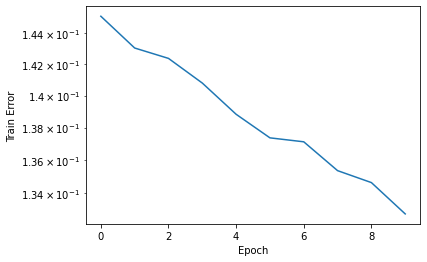

1192/1192 [==============================] - 9s 7ms/step - loss: 0.1716 - mse: 0.1704 - mae: 0.1716 - false_negatives_2: 3325.0000 - false_positives_2: 3213.0000 - true_negatives_1: 14873.0000 - true_positives_1: 16717.0000 - accuracy: 0.7435


[0.1716364026069641,
 0.17038828134536743,
 0.1716364026069641,
 3325.0,
 3213.0,
 14873.0,
 16717.0,
 0.7434955835342407]

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)

model.evaluate([test.user_id, test.movie_id], test.rating)